In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tools
from matplotlib.ticker import FuncFormatter
from matplotlib.widgets import Slider, Button
import copy

In [2]:
%matplotlib qt

In [10]:
class K(tools.K):
    # INITIATION
    l = 1e9 * 0.00001  # 8 10
    l_ = 1e5  # 5 6

    qE = 1e9  # 8 10
    qE_ = 1e8  # 7 9
    H = 1e9  # 8 10

    qH = 1e6  # 2000
    redQ = 1e9
    oxQ = 1

    qQD = 2

    qPh = 1e-5

    D = 1
    D_ = 0.05

    r = 1e9
    p = 0.0001

    rD = 1e9

    # POLYMERIZATION
    pI = 0
    pP = 1e4
    pDD = 0
    pDrP = 0
    pDdP = 0


class K2(tools.K):
    # INITIATION
    l = 1e9 * 0.00001  # 8 10
    l_ = 1e6  # 5 6

    qE = 1e10  # 8 10
    qE_ = 1e7  # 7 9
    H = 1e9  # 8 10

    qH = 1e5  # 2000
    redQ = 1e9
    oxQ = 1

    qQD = 2

    qPh = 1e-5

    D = 1
    D_ = 0.05

    r = 1e9
    p = 0.0001

    rD = 1e8


class K_sweep(tools.K):
    # INITIATION

    l = 1e9 * 0.00001  # 8 10
    l_ = 1e5  # 5 6

    qE = 1e9  # 8 10
    qE_ = 1e8  # 7 9
    H = 1e9  # 8 10

    qH = 1e6  # 2000
    redQ = 1e9

    r = 1e9

    rD = 1e9

In [4]:
T = np.linspace(0, 0.001, 100)

In [5]:
def system_full(t, C, k=K()):
    [Q, Qt, DH, Q_DH, QH, D, QHH, QHD, QD] = C
    C1 = Q
    C2 = Qt
    C3 = DH
    C4 = Q_DH
    C5 = QH
    C6 = D
    C7 = QHH
    C8 = QHD
    C9 = QD

    R1 = k.l * C1
    R2 = k.l_ * C2
    R3 = k.qE * C2 * C3
    R4 = k.qE_ * C4
    R5 = k.H * C4
    R6 = k.qH * C2 * C7
    R7 = k.redQ * C5 * C5
    R8 = k.oxQ * C1 * C7
    R9 = k.qQD * C2 * C8
    R10 = k.qPh * C2
    R11 = k.D * C1 * C6
    R12 = k.D_ * C9
    R13 = k.r * C5 * C6
    R14 = k.p * C8
    R15 = k.rD * C6 * C6

    res = dict(
        dCl=-R1 + R2 + R7 - R8 - R11 + R12,
        dC2=R1 - R2 - R3 + R4 - R6 - R9 - R10,
        dC3=-R3 + R4,
        dC4=R3 - R4 - R5,
        dC5=R5 + 2 * R6 - 2 * R7 + 2 * R8 + R9 - R13,
        dC6=R5 - R11 + R12 - R13 - 2 * R15,
        dC7=-R6 + R7 - R8 + R14,
        dC8=-R9 + R13 - R14,
        dC9=R9 + R11 - R12,
    )

    return list(res.values())


c_full = '[Q, Qt, DH, Q_DH, QH, D, QHH, QHD, QD]'
initial_full = [10, 0, 10, 0, 0, 0, 2, 0, 0]
init_full=tools.get_init(c_full,initial_full)

In [6]:
def system_base(t, C, k=K()):
    [Q, Qt, DH, QH, D, QHH] = C

    R1 = k.l * Q
    R2 = k.l_ * Qt
    R3 = k.H * Qt * DH
    R6 = k.qH * Qt * QHH
    R7 = k.redQ * QH * QH
    R13 = k.r * QH * D
    R15 = k.rD * D * D

    res = dict(
        Q=-R1 + R2 + R7,
        Qt=R1 - R2 - R3 - R6,
        DH=-R3,
        QH=R3 + 2 * R6 - 2 * R7 - R13,
        D=R3 - R13 - 2 * R15,
        QHH=-R6 + R7,
    )

    return list(res.values())


c_base = '[Q, Qt, DH, QH, D, QHH]'
initial_base = [1, 0, 1, 0, 0, 0]
init_base=tools.get_init(c_base,initial_base)

In [7]:
def pol_base(t, C, k=K()):
    [Q, Qt, DH, QH, D, QHH, M, DM, P] = C

    R1 = k.l * Q
    R2 = k.l_ * Qt
    R3 = k.H * Qt * DH
    R4 = k.qH * Qt * QHH
    R5 = k.redQ * QH * QH
    R6 = k.r * QH * D
    R7 = k.rD * D * D
    R8 = k.pI * D * M
    R9 = k.pP * DM * M
    R10 = k.pP * P * M
    R11 = k.pDD * P * D
    R12 = k.pDrP * P * P
    R13 = k.pDdP * P * P

    res = dict(
        Q=-R1 + R2 + R5,
        Qt=R1 - R2 - R3 - R4,
        DH=-R3,
        QH=R3 + 2 * R4 - 2 * R5 - R6,
        D=R3 - R6 - 2 * R7 - R8 - R11,
        QHH=-R4 + R5,
        M=-R8 - R9 - R10,
        DM=R8 - R9,
        P=R9 - R11 - 2 * R12 - 2 * R13,
    )
    return list(res.values())


c_pol = '[Q, Qt, DH, QH, D, QHH, M, DM, P]'
initial_pol = [1, 0, 1, 0, 0, 0, 0, 0, 0]

In [28]:
class K_old(tools.K):
    # INITIATION
    i = 1e9 * 0.00001  # 8 10

    p = 0.0001
    l = 1
    q = 2


def pol_old(t, C, k=K_old()):
    [Q, D, M, P] = C

    R1 = k.i * Q
    R2 = k.p * D * M
    R3 = k.l * P
    R4 = k.q * P * P

    res = dict(
        Q=-R1,
        D=R1 - R2,
        M=-R2,
        P=R2 - R3 - 2 * R4,
    )
    return list(res.values())


c_old = '[Q, D, M, P]'
initial_old = [0.001, 0, 5, 0]
init_old =tools.get_init(c_old,initial_old)

#   Plot

In [8]:
class K(tools.K):
    # INITIATION
    l = 1e9 * 0.00001  # 8 10
    l_ = 1e5  # 5 6

    qE = 1e9  # 8 10
    qE_ = 1e8  # 7 9
    H = 1e9  # 8 10

    qH = 1e6  # 2000
    redQ = 1e9
    oxQ = 1

    qQD = 2

    qPh = 1e-5

    D = 1
    D_ = 0.05

    r = 1e9
    p = 0.0001

    rD = 1e9

In [9]:
class K2(tools.K):
    # INITIATION
    l = 1e9 * 1e-5  # 8 10
    l_ = 1e6  # 5 6

    qE = 1e10  # 8 10
    qE_ = 1e7  # 7 9
    H = 1e9  # 8 10

    qH = 1e5  # 2000
    redQ = 1e9
    oxQ = 1

    qQD = 2

    qPh = 1e-5

    D = 1
    D_ = 0.05

    r = 1e9
    p = 0.0001

    rD = 1e8

# Comparation

In [29]:
Y = tools.Solver(pol_old, K_old(), init_old, T)
LIM = None
AUTO = True
compounds = dict(
    Q=1,
    D=1,
    M=0,
    P=1,
)

In [26]:
# Y = tools.Solver(system_full, K2(), init_full,  T)

# LIM = None
# AUTO = True
# compounds = dict(
#     Q=0,
#     DH=0,
#     QHH=0,
#     QH=2,
#     # M=0,
#     D=1,
#     Qt=2,
# )

In [27]:
# Plots

fig, ax = plt.subplots()
gs = plt.GridSpec(2, 2, figure=fig)
fig.subplots_adjust(left=0.25, right=0.99, bottom=0.05, top=0.99, hspace=0.1, wspace=0.1)
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
scal = FuncFormatter(lambda x, pos: f'{x*1000: .2f}')

K_base = Y.K


def get_ax(gs, keys_num):
    ax = plt.subplot(gs)
    for c in [key for key, value in compounds.items() if value == keys_num]:
        plots[c] = ax.plot(Y.T, Y[c], label=c)[0]
    ax.legend()
    ax.xaxis.set_major_formatter(scal)
    if LIM is not None:
        ax.set_ylim([-LIM, LIM])


    return ax


# Plots
plots = {}
ax0 = get_ax(gs=gs[0, 0:2], keys_num=0)
ax1 = get_ax(gs=gs[1, 0], keys_num=1)
ax2 = get_ax(gs=gs[1, 1], keys_num=2)

# Sliders
sliders = {}
buttons = {}
K_new = copy.deepcopy(K_base)


def resolve(event=None):
    Y.solve(K=K_new)
    for c, plot in plots.items():
        plot.set_ydata(Y[c])
    fig.canvas.draw_idle()


def get_slider_action(k):
    def update(val):
        K_new[k] = K_base[k] * 10**val
        buttons[k].label.set_text(f"{K_new[k]: .1e}")
        if AUTO:
            resolve()

    return update


def get_zero_button_action(k):
    def update(event):
        K_new[k] = 0
        buttons[k].label.set_text(f"{K_new[k]: .1e}")
        fig.canvas.draw_idle()
        if AUTO:
            resolve()

    return update


def reset(event):
    global K_new
    K_new = copy.deepcopy(K_base)
    for k in sliders:
        sliders[k].reset()
        buttons[k].label.set_text(f"{K_new[k]: .1e}")
    fig.canvas.draw_idle()
    if AUTO:
        resolve()


solve_axes = fig.add_axes([0.02, 0.05, 0.05, 0.05])
solve_button = Button(solve_axes, 'Solve', hovercolor='0.975')
solve_button.on_clicked(resolve)

reset_axes = fig.add_axes([0.08, 0.05, 0.05, 0.05])
reset_button = Button(reset_axes, 'Reset', hovercolor='0.975')
reset_button.on_clicked(reset)

for i, k in enumerate(K_base):
    k_axes = fig.add_axes(
        [
            0.03,  # left
            0.95 - 0.04 * i,  # bottom
            0.10,  # width
            0.03,  # height
        ]
    )
    amp_slider = Slider(
        ax=k_axes,
        label=k,
        valmin=-3,
        valmax=3,
        valinit=0,
        valstep=0.1,
        orientation="horizontal",
    )
    sliders[k] = amp_slider
    amp_slider.on_changed(get_slider_action(k))

    k_zero_axes = fig.add_axes(
        [
            0.15,  # left
            0.955 - 0.04 * i,  # bottom
            0.05,  # width
            0.02,  # height
        ]
    )
    zero_button = Button(k_zero_axes, f"{K_new[k]: .1e}", hovercolor='0.975')
    buttons[k] = zero_button
    zero_button.on_clicked(get_zero_button_action(k))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


# results

In [41]:
res= pd.read_csv('result.csv',index_col=0)

In [54]:
uncorrect = res[res['status']!='ERROR']
uncorrect=uncorrect[uncorrect['D']>1e-2]

correct = res[res['status']!='ERROR']
correct=correct[correct['D']<=1e-2]

In [55]:
%matplotlib qt

In [56]:
plt.scatter( uncorrect.index, uncorrect['D'])

In [4]:
errors= res[res['status']=='ERROR']

In [20]:
ks ='[l, l_, qE, qE_, H, qH, redQ, r, rD, Q, QHH, DH]'[1:-1].split(', ')
ks

['l', 'l_', 'qE', 'qE_', 'H', 'qH', 'redQ', 'r', 'rD', 'Q', 'QHH', 'DH']

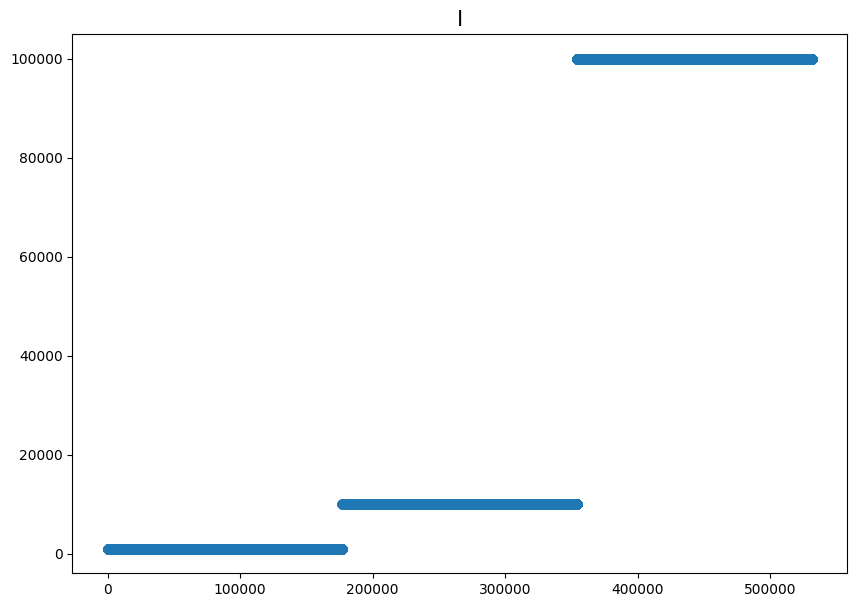

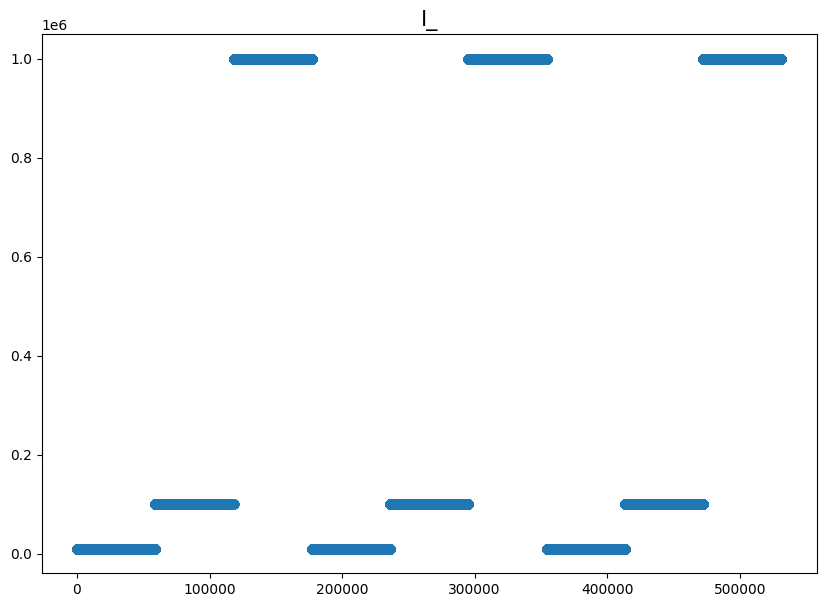

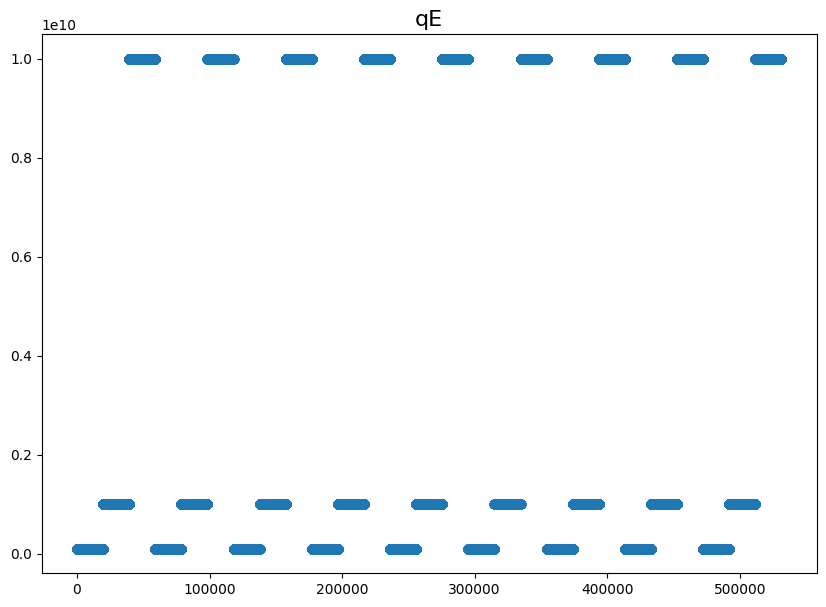

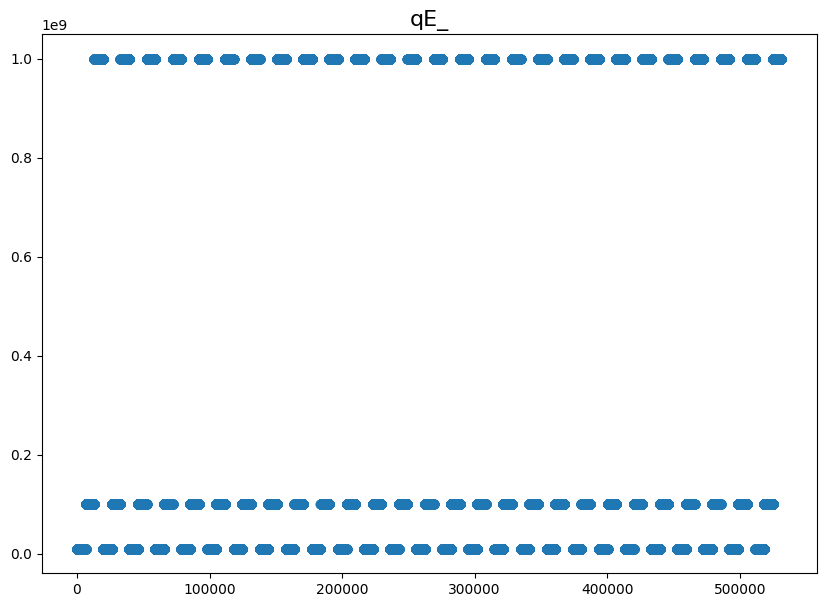

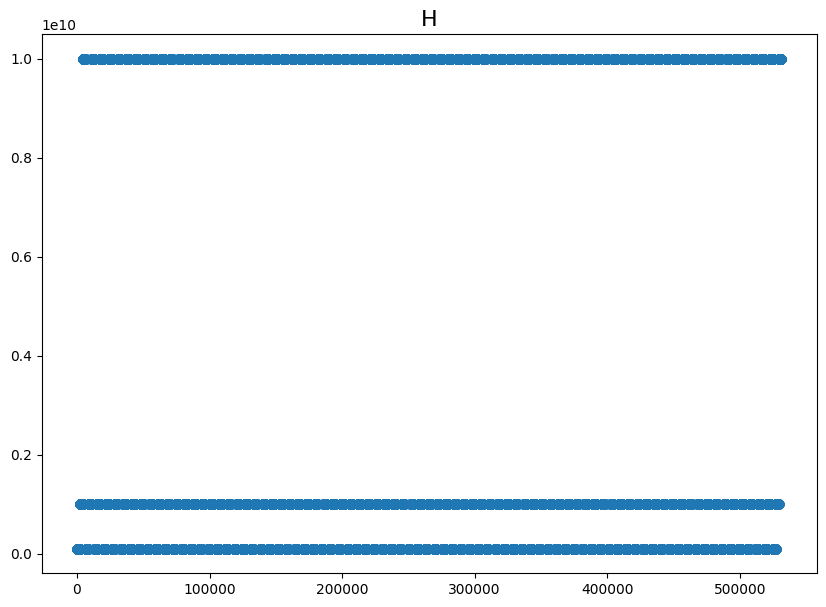

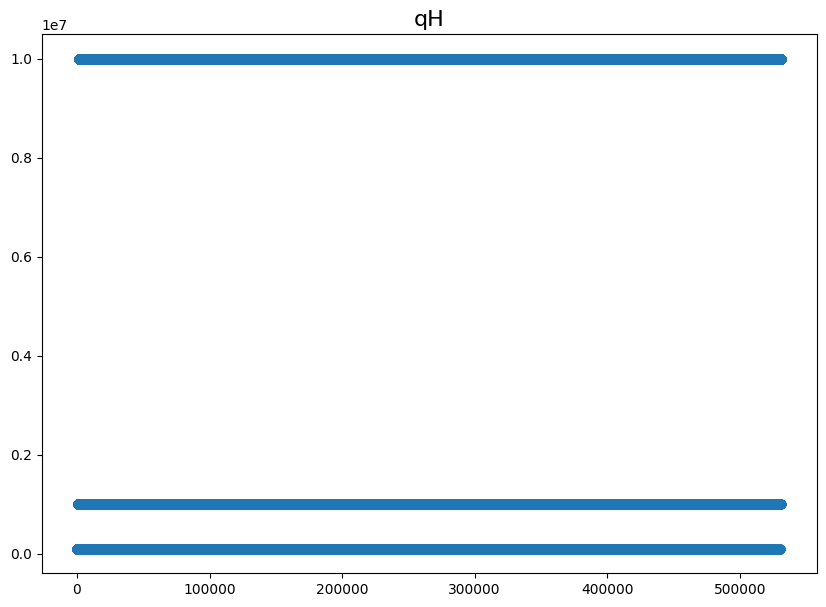

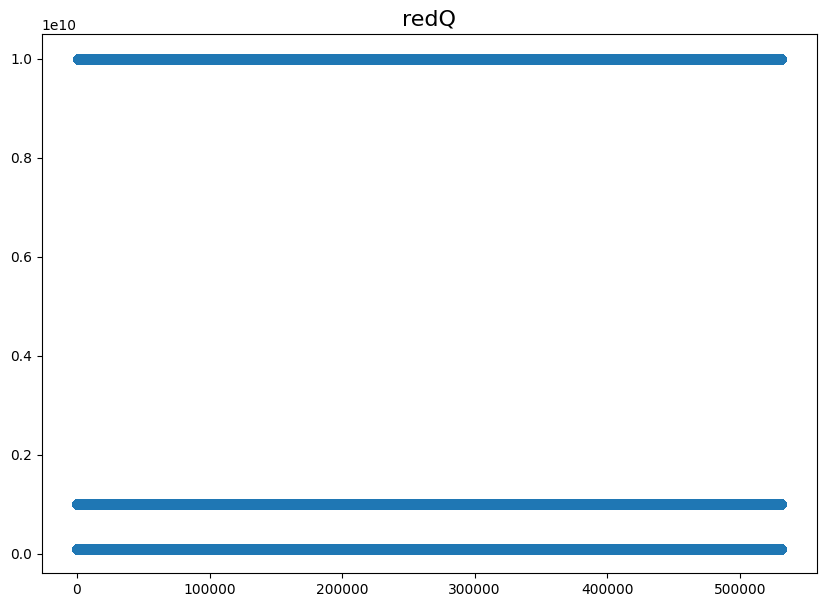

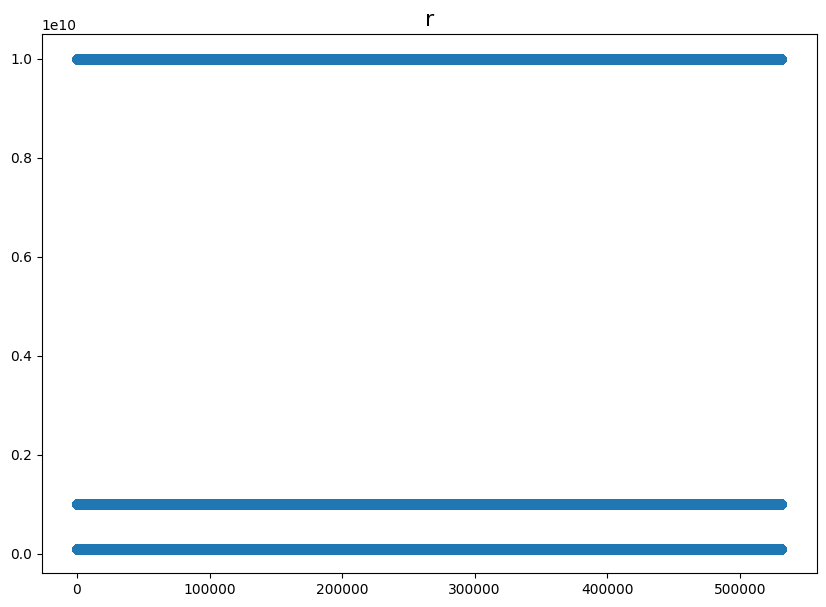

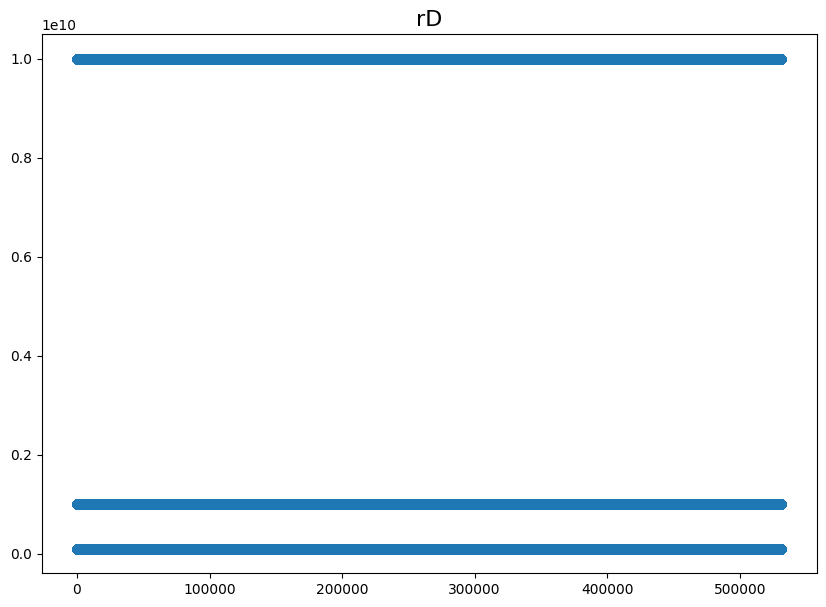

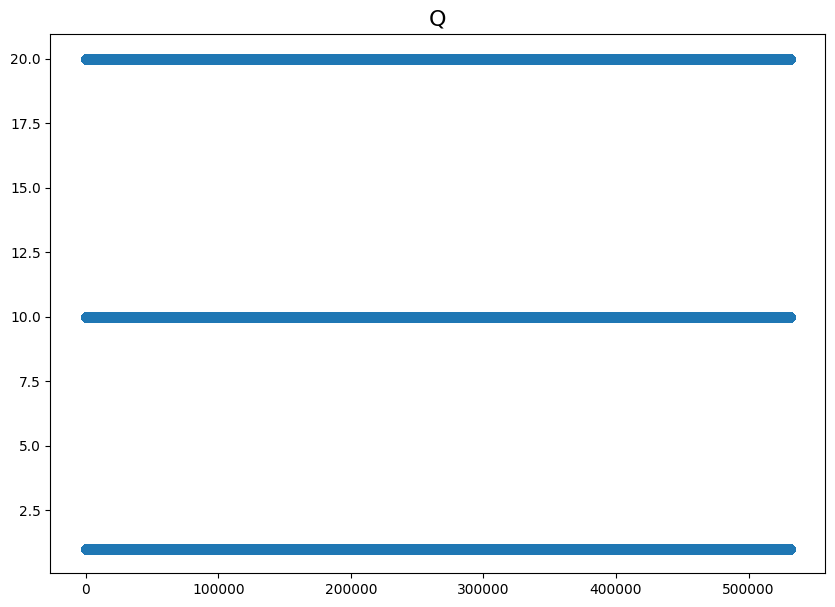

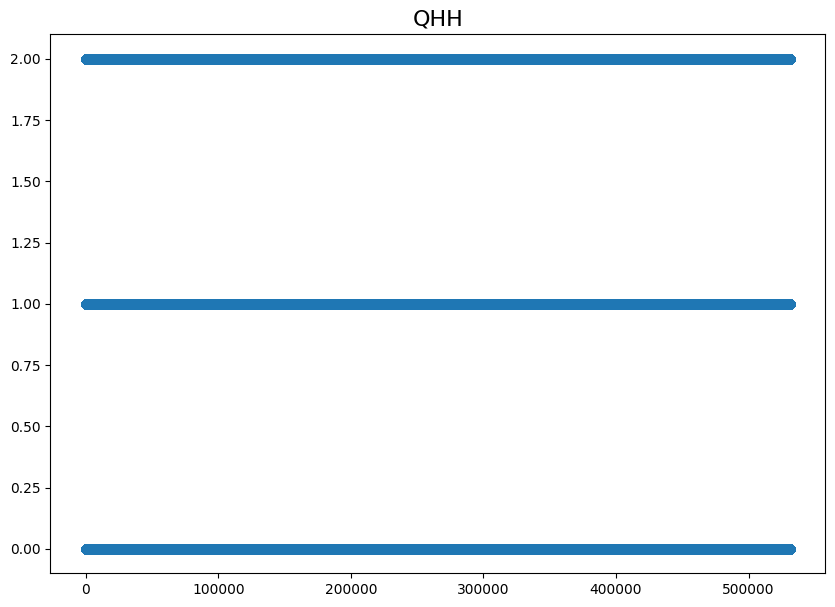

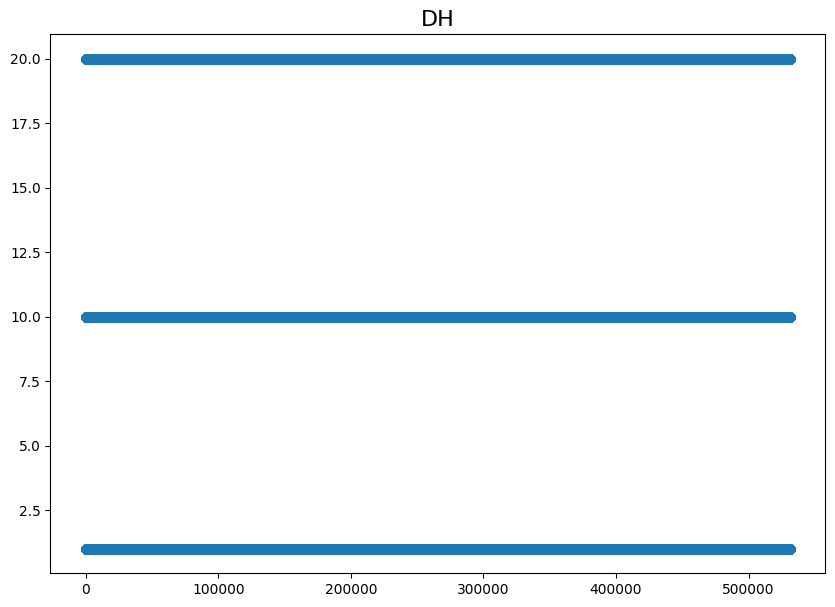

In [23]:
num=1
for key in ks:
    fig,ax = plt.subplots()
    ax.scatter(correct[key].index,correct[key])
    ax.set_title(key)

# Polimersization